### Pretraining encoder on CIFAR-100

In [1]:
# Import necessary libraries

import gc
import torch
import numpy as np
import matplotlib.pyplot as plt


import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.amp import autocast, GradScaler

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from tqdm import tqdm

def clear_memory():
    """Clear GPU memory cache"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

def get_device():
    """Get the best available device with optimized settings"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.set_per_process_memory_fraction(0.8)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.set_default_dtype(torch.float32)
        clear_memory()
    else:
        device = torch.device('cpu')
    torch.set_default_device(device)
    return device

clear_memory()


In [2]:
# Hyperparameters and configurations

class CFG:
    seed = 42
    n_epochs = 15
    batch_size = 128
    lr = 1e-4
    wd = 1e-4
    lrd_step = 10
    lrd_gamma = 0.8
    maxnorm = 1.0
    hflipP = 0.5
    train_split = 0.8
    patience = 2
    lr_factor = 0.5
    rot_deg = 10
    dropout_p = 0.3
    use_amp = True  # Enable mixed precision

torch.manual_seed(CFG.seed)
np.random.seed(CFG.seed)

In [3]:
# Download the dataset
train_dataset = datasets.CIFAR100(root='data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR100(root='data', train=False, download=True, transform=transforms.ToTensor())

# Find the respective mean and standard deviations of the datasets
train_s = torch.stack([data[0] for data in train_dataset])
test_s = torch.stack([data[0] for data in test_dataset])
train_mean, train_std = train_s.mean(axis=(0, 2, 3)).numpy(), train_s.std(axis=(0, 2, 3)).numpy()
test_mean, test_std = test_s.mean(axis=(0, 2, 3)).numpy(), test_s.std(axis=(0, 2, 3)).numpy()


print(f"Train Mean: {train_mean}, Train Std: {train_std}")
print(f"Test Mean: {test_mean}, Test Std: {test_std}")

# Normalisation and Augmentation
train_transform = transforms.Compose([
  transforms.RandomHorizontalFlip(p=CFG.hflipP),
  transforms.RandomRotation(degrees=CFG.rot_deg),
  transforms.Resize((128, 128)),
  transforms.ToTensor(),
  transforms.Normalize(train_mean, train_std)
])


test_transform = transforms.Compose([
  transforms.Resize((128, 128)),
  transforms.ToTensor(),
  transforms.Normalize(test_mean, test_std)
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

Files already downloaded and verified
Files already downloaded and verified
Train Mean: [0.5070758  0.4865503  0.44091913], Train Std: [0.26733428 0.25643846 0.27615047]
Test Mean: [0.508796   0.4873928  0.44194147], Test Std: [0.2682516  0.25736374 0.2770958 ]


In [4]:
# Split training data into training and validation sets
train_size = int(CFG.train_split * train_dataset.data.shape[0])
val_size = train_dataset.data.shape[0] - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
print(f"Train size: {train_size}, Val size: {val_size},", end=" ")

# Add train and val datasets to dataloaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True,
                          generator=torch.Generator(device=device))
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False,
                        generator=torch.Generator(device=device))
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False,
                         generator=torch.Generator(device=device))

Train size: 40000, Val size: 10000, Device: cuda


In [5]:
# # Sample batch
# for images, _ in train_loader:
#   print('Sample batch; Shape:', images.shape)
#   images = images.cpu()
#   images = images * np.mean(train_mean) + np.mean(train_std)
#   plt.figure(figsize=(32, 32))
#   plt.axis('off')
#   plt.imshow(make_grid(images, nrow=32).permute((1, 2, 0)))
#   plt.show()
#   break

In [6]:
# Creating the CNN model

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.encoder = nn.Sequential(
      # Input: 128 x 128 x 3
      nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
      # Output: 128 x 128 x 32
      nn.ReLU(),
      nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
      # Output: 128 x 128 x 32
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Output: 64 x 64 x 32

      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      # Output: 64 x 64 x 64
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      # Output: 64 x 64 x 64
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Output: 32 x 32 x 64

      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      # Output: 32 x 32 x 128
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      # Output: 32 x 32 x 128
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Output: 16 x 16 x 128

      nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
      # Output: 16 x 16 x 256
      nn.ReLU(),
      nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
      # Output: 16 x 16 x 256
      nn.ReLU()
    )

    self.dense_layers = nn.Sequential(
      nn.Flatten(),
      # Output: 16*16*256 = 65536 x 1
      nn.Linear(65536, 256),
      # Output: 512 x 1
      nn.ReLU(),
      nn.Linear(256, 256),
      # Output: 256 x 1
      nn.ReLU(),
      nn.Linear(256, 100)
      # Output: 100 x 1
    )
    
    self.features = nn.Sequential(
      nn.Flatten(),
      nn.Linear(65536, 768),
    )
    # Apply Xavier Initialization
    self.init_xavier()

  def init_xavier(self):
    for layer in self.modules():
      if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
          nn.init.constant_(layer.bias, 0)

  def forward(self, x):
    x = self.encoder(x)
    feat = self.features(x)
    x = self.dense_layers(x)
    return x, feat

In [7]:
device = get_device()
print(device)
clear_memory()

model = CNN()
load_model = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = StepLR(optimizer, step_size=CFG.lrd_step, gamma=CFG.lrd_gamma)
scaler = GradScaler('cuda') if device.type == 'cuda' else None

cuda


In [8]:
model = model.to(device)
criterion.to(device)
train_losses, val_losses = [], []
best_val_loss = float('inf')
for epoch in range(CFG.n_epochs):

  # Training phase
  model.train()
  train_loss = 0.0
  progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CFG.n_epochs}", unit="batch")
  for idx, (images, labels) in enumerate(progress_bar):
    try:
      images, labels = images.to(device), labels.to(device)
      with autocast(device_type='cuda', dtype=torch.float16, enabled=CFG.use_amp):
        output, _ = model(images)
        loss = criterion(output, labels)
      optimizer.zero_grad()
      
      if scaler is not None:
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.maxnorm)
        scaler.step(optimizer)
        scaler.update()
      else:
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.maxnorm)
        optimizer.step()

      train_loss += loss.item()
      avg_loss = train_loss / (idx + 1)
      progress_bar.set_postfix({"Avg Loss": f"{avg_loss:.4f}"})

      # Clear memory after each batch
      if device.type == 'cuda':
          del images, labels, output, loss
          clear_memory()

    except RuntimeError as e:
        if "CUBLAS" in str(e) or "out of memory" in str(e):
            print(f'WARNING: CUDA error encountered, clearing cache and skipping batch: {str(e)}')
            if device.type == 'cuda':
                clear_memory()
            continue
        else:
            raise e

  avg_loss = train_loss / len(train_loader)
  train_losses.append(avg_loss)

  # Validation phase
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      output, _ = model(images)
      loss = criterion(output, labels)
      val_loss += loss.item()

      if device.type == 'cuda':
          del images, labels, output, loss
          clear_memory()

  avg_val_loss = val_loss / len(val_loader)
  val_losses.append(avg_val_loss)
  print(f"Epoch [{epoch+1}/{CFG.n_epochs}] || Avg Train Loss: {avg_loss:.6f} || Avg Val Loss: {avg_val_loss:.6f} || Current LR: {optimizer.param_groups[0]['lr']}")
  
  scheduler.step()
  
  # Early stopping
  if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      patience_counter = 0
      torch.save(model.state_dict(), 'CNN.pth')
  else:
      patience_counter += 1
      if patience_counter >= CFG.patience:
          print(f'Early stopping triggered after {epoch+1} epochs')
          break
    
# Save the model
torch.save(model.state_dict(), 'CNN.pth')

Epoch 1/15: 100%|██████████| 313/313 [01:42<00:00,  3.06batch/s, Avg Loss=4.0763]


Epoch [1/15] || Avg Train Loss: 4.076293 || Avg Val Loss: 3.715256 || Current LR: 0.0001


Epoch 2/15: 100%|██████████| 313/313 [01:39<00:00,  3.14batch/s, Avg Loss=3.4881]


Epoch [2/15] || Avg Train Loss: 3.488118 || Avg Val Loss: 3.363697 || Current LR: 0.0001


Epoch 3/15: 100%|██████████| 313/313 [01:41<00:00,  3.09batch/s, Avg Loss=3.1598]


Epoch [3/15] || Avg Train Loss: 3.159801 || Avg Val Loss: 3.083621 || Current LR: 0.0001


Epoch 4/15: 100%|██████████| 313/313 [01:43<00:00,  3.01batch/s, Avg Loss=2.9036]


Epoch [4/15] || Avg Train Loss: 2.903611 || Avg Val Loss: 2.950287 || Current LR: 0.0001


Epoch 5/15: 100%|██████████| 313/313 [01:45<00:00,  2.96batch/s, Avg Loss=2.6931]


Epoch [5/15] || Avg Train Loss: 2.693128 || Avg Val Loss: 2.827974 || Current LR: 0.0001


Epoch 6/15: 100%|██████████| 313/313 [01:45<00:00,  2.98batch/s, Avg Loss=2.4946]


Epoch [6/15] || Avg Train Loss: 2.494572 || Avg Val Loss: 2.721447 || Current LR: 0.0001


Epoch 7/15: 100%|██████████| 313/313 [01:44<00:00,  2.98batch/s, Avg Loss=2.3273]


Epoch [7/15] || Avg Train Loss: 2.327293 || Avg Val Loss: 2.682968 || Current LR: 0.0001


Epoch 8/15: 100%|██████████| 313/313 [01:45<00:00,  2.97batch/s, Avg Loss=2.1436]


Epoch [8/15] || Avg Train Loss: 2.143623 || Avg Val Loss: 2.669829 || Current LR: 0.0001


Epoch 9/15: 100%|██████████| 313/313 [01:45<00:00,  2.96batch/s, Avg Loss=1.9754]


Epoch [9/15] || Avg Train Loss: 1.975351 || Avg Val Loss: 2.661564 || Current LR: 0.0001


Epoch 10/15: 100%|██████████| 313/313 [01:45<00:00,  2.96batch/s, Avg Loss=1.8072]


Epoch [10/15] || Avg Train Loss: 1.807228 || Avg Val Loss: 2.671732 || Current LR: 0.0001


Epoch 11/15: 100%|██████████| 313/313 [01:44<00:00,  2.98batch/s, Avg Loss=1.5812]


Epoch [11/15] || Avg Train Loss: 1.581192 || Avg Val Loss: 2.647521 || Current LR: 8e-05


Epoch 12/15: 100%|██████████| 313/313 [01:45<00:00,  2.97batch/s, Avg Loss=1.4247]


Epoch [12/15] || Avg Train Loss: 1.424659 || Avg Val Loss: 2.754455 || Current LR: 8e-05


Epoch 13/15: 100%|██████████| 313/313 [01:45<00:00,  2.97batch/s, Avg Loss=1.2744]


Epoch [13/15] || Avg Train Loss: 1.274375 || Avg Val Loss: 2.855325 || Current LR: 8e-05
Early stopping triggered after 13 epochs


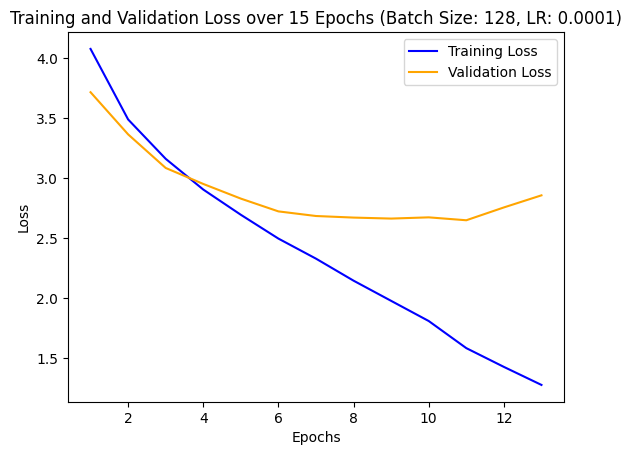

In [9]:
# Plot training loss
plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss", color="orange")
plt.title(f"Training and Validation Loss over {CFG.n_epochs} Epochs (Batch Size: {CFG.batch_size}, LR: {CFG.lr})")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
# Testing phase
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    outputs, _ = model(images)
    _, preds = torch.max(outputs, 1)

    all_preds.append(preds.cpu())
    all_labels.append(labels.cpu())

    # Clear memory after each batch
    if device.type == 'cuda':
        del images, labels, outputs
        clear_memory()

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

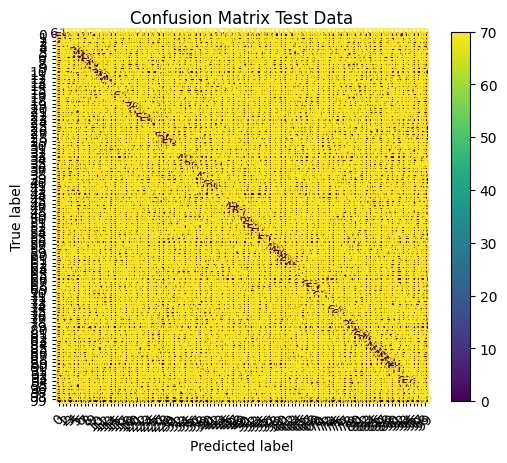

              precision    recall  f1-score   support

           0       0.75      0.61      0.67       100
           1       0.44      0.55      0.49       100
           2       0.25      0.26      0.25       100
           3       0.28      0.18      0.22       100
           4       0.20      0.28      0.23       100
           5       0.32      0.36      0.34       100
           6       0.36      0.45      0.40       100
           7       0.54      0.47      0.50       100
           8       0.51      0.56      0.54       100
           9       0.56      0.48      0.52       100
          10       0.22      0.26      0.24       100
          11       0.18      0.36      0.24       100
          12       0.42      0.47      0.44       100
          13       0.33      0.46      0.39       100
          14       0.46      0.22      0.30       100
          15       0.38      0.20      0.26       100
          16       0.49      0.32      0.39       100
          17       0.55    

In [11]:
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(all_labels, all_preds))
disp.plot(xticks_rotation=45)
plt.title('Confusion Matrix Test Data')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds))